In [12]:
import numpy as np
import pyro
import matplotlib.pyplot as plt
import torch
from torch.distributions import constraints
import arviz as az

import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS
from pyro.infer import MCMC

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0)

Plot helper functions

In [3]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-1, 1)

Define data

In [4]:
def f(x):
    return np.sin(20*x)+2*np.cos(14*x)-2*np.sin(6*x)

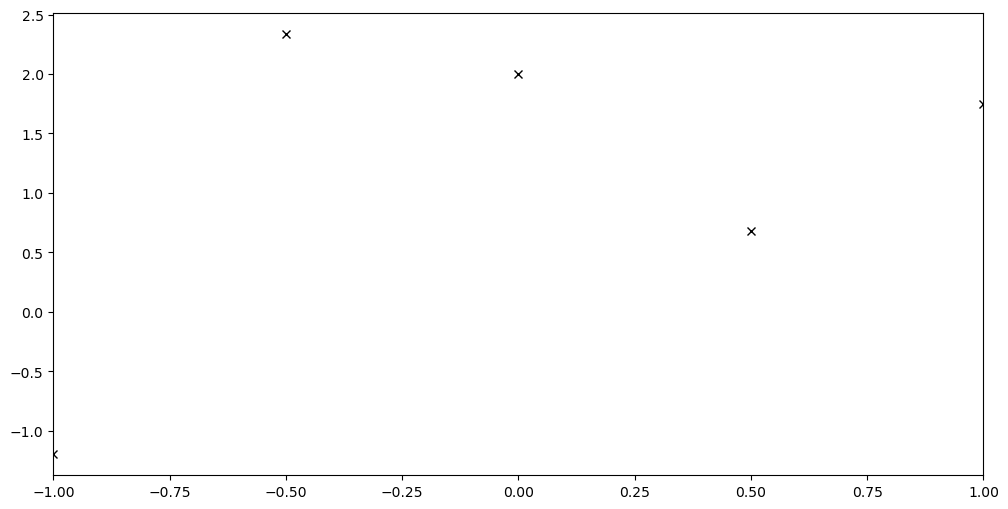

In [5]:
N = 5
X = torch.tensor([-1,-0.5,0,0.5,1])
y = f(X)
# Let's plot the observed data
plot(plot_observed_data=True)

Define model

##### From ChatGPT

In [ ]:
class GaussianRBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        
        # initialize the weight and bias parameters
        self.weights = pyro.param("weights", torch.randn(num_visible, num_hidden))
        self.visible_bias = pyro.param("visible_bias", torch.randn(num_visible))
        self.hidden_bias = pyro.param("hidden_bias", torch.randn(num_hidden))

    def model(self, visible):
        hidden = pyro.sample("hidden", dist.Bernoulli(logits=self.hidden_bias + visible @ self.weights))
        visible = pyro.sample("visible", dist.Normal(self.visible_bias, 1).to_event(1))
        return hidden, visible

    def guide(self, visible):
        hidden_mean = torch.sigmoid(self.hidden_bias + visible @ self.weights)
        hidden = pyro.sample("hidden", dist.Bernoulli(hidden_mean))
        return hidden

In [ ]:
# create an instance of the Gaussian RBM
rbm = GaussianRBM(num_visible=784, num_hidden=500)

In [ ]:
# use Pyro's SVI to train the model
svi = pyro.infer.SVI(rbm.model, rbm.guide, pyro.optim.Adam({'lr': 0.001}), loss=pyro.infer.Trace_ELBO())
for step in range(1000):
    svi.step(torch.randn(100, 784))

##### From tutorial

In [45]:
#From tutorial
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05) #defaults: 6.0 and 0.05
)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.), torch.tensor(2.0)))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.0001)) 

##### From Medium

In [144]:
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_h_given_h = torch.sigmoid(activation)
        return p_h_given_h, torch.bernoulli(p_h_given_h)
    def train(self, v0, vk, ph0, phk):
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

In [153]:
nv = len(X)
nh = 100
batch_size = 100
rbm = RBM(nv, nh)
gpr = gp.models.GPRegression(X, y, rbm, noise=torch.tensor(0.001)) #noise should be 10^-4

In [ ]:
nb_epoch = 10
for epoch in range(1,nb_epoch+1):
    train_loss = 0
    s = 0
    for x_value in 

##### Plot

ValueError: Expected parameter covariance_matrix (Tensor of shape (500, 500)) of distribution MultivariateNormal(loc: torch.Size([500]), covariance_matrix: torch.Size([500, 500])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[1.8039e-03, 8.6531e-04, 9.3101e-04,  ..., 6.7712e-09, 5.9996e-09,
         5.3139e-09],
        [7.8954e-04, 1.8499e-03, 9.1451e-04,  ..., 6.9742e-09, 6.1801e-09,
         5.4743e-09],
        [7.7539e-04, 8.3475e-04, 1.8983e-03,  ..., 7.1832e-09, 6.3659e-09,
         5.6394e-09],
        ...,
        [5.6394e-09, 6.3659e-09, 7.1832e-09,  ..., 1.8983e-03, 8.3475e-04,
         7.7539e-04],
        [5.4743e-09, 6.1801e-09, 6.9742e-09,  ..., 9.1451e-04, 1.8499e-03,
         7.8954e-04],
        [5.3139e-09, 5.9996e-09, 6.7712e-09,  ..., 9.3101e-04, 8.6531e-04,
         1.8039e-03]], grad_fn=<ExpandBackward0>)

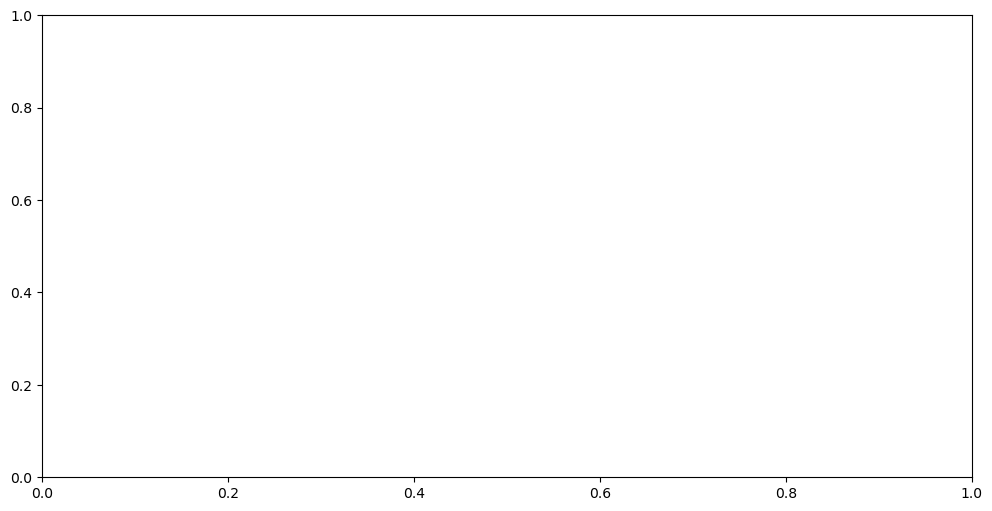

In [22]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-5, 5))

##### Inference

Change something in model definition or here in inference (Use NUTS)

In [30]:
# Variational inference
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 1000 if not smoke_test else 2 #default num_steps = 2000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [46]:
# MCMC
hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=200, num_chains=5)
mcmc.run()

Warmup [1]:   0%|          | 0/400 [00:00, ?it/s]





Warmup [1]:   8%|▊         | 32/400 [00:06, 10.69it/s, step size=1.52e-01, acc. prob=0.800]

Warmup [1]:   8%|▊         | 34/400 [00:06, 10.58it/s, step size=3.75e-01, acc. prob=0.810]


Warmup [1]:   9%|▉         | 36/400 [00:06, 11.30it/s, step size=1.05e+00, acc. prob=0.820]


Warmup [1]:  12%|█▏        | 46/400 [00:06, 14.76it/s, step size=6.75e-01, acc. prob=0.813]

Warmup [1]:  13%|█▎        | 52/400 [00:07, 17.00it/s, step size=4.12e-01, acc. prob=0.808]


Warmup [1]:  14%|█▍        | 56/400 [00:07, 21.82it/s, step size=2.16e-01, acc. prob=0.803]












Warmup [1]:  15%|█▌        | 60/400 [00:07, 14.48it/s, step size=1.21e-01, acc. prob=0.798]








Warmup [1]:  16%|█▌        | 63/400 [00:08, 13.62it/s, step size=3.66e-01, acc. prob=0.806]


Warmup [1]:  16%|█▋        | 66/400 [00:08, 15.67it/s, step size=5.04e-01, acc. prob=0.808]





Warmup [1]:  17%|█▋        | 69/400 [00:08, 15.89it/s, step size=2.07e-01, acc. pr

##### Plots

In [10]:
# let's plot the loss curve after num_steps steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

plot_loss(losses)

NameError: name 'losses' is not defined

Did we learn anything about the model?

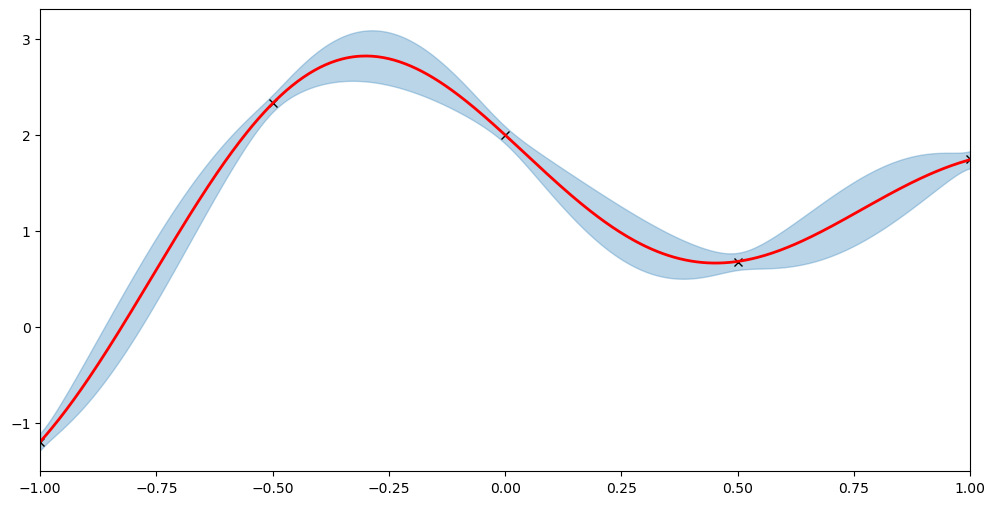

In [64]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

##### Diagnostics

In [61]:
# Get the samples
ls_name = "kernel.lengthscale"
v_name = "kernel.variance"
posterior_ls = mcmc.get_samples()[ls_name]
posterior_v  = mcmc.get_samples()[v_name]

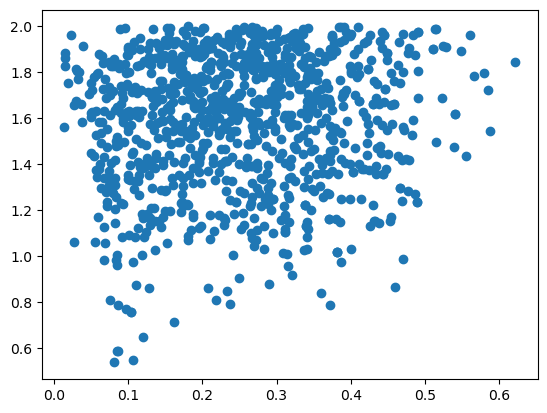

In [62]:
plt.scatter(posterior_ls,posterior_v)

In [49]:
Xnew = torch.tensor([-0.75, -0.25, 0.25, 0.75])
f_loc, f_cov = gpr(Xnew, full_cov=True)

In [51]:
data = az.from_pyro(mcmc)
summary = az.summary(data)
print(summary) 

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.251  0.121   0.049    0.466      0.006    0.004   
kernel.variance     1.583  0.288   1.101    1.998      0.013    0.009   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     402.0     379.0   1.02  
kernel.variance        399.0     304.0   1.01  


c:\Users\malth\anaconda3\envs\myenvyaml\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


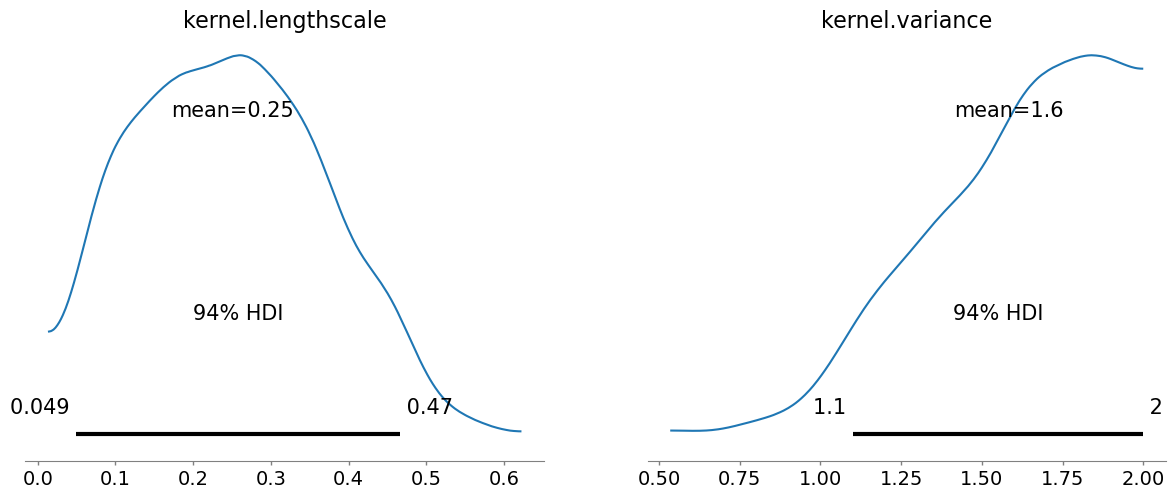

In [52]:
az.plot_posterior(data)
plt.show()

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

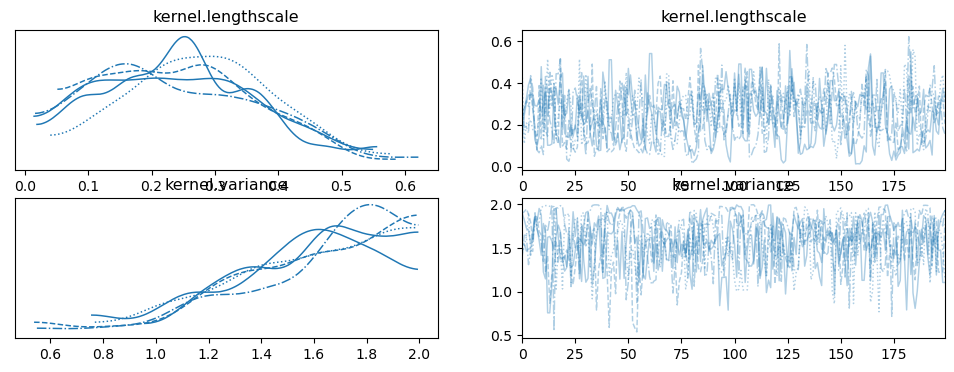

In [53]:
az.plot_trace(data)

##### Big plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


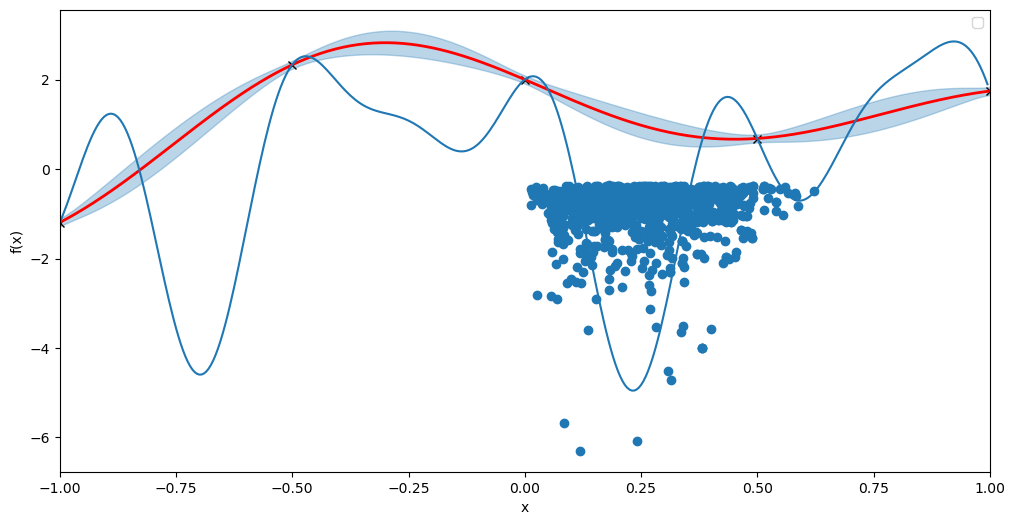

In [100]:
x_seq = np.arange(start=-1,stop=1,step=0.005)
plot(model=gpr, plot_observed_data=True, plot_predictions=True)
plt.plot(x_seq,f(x_seq))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend() #Elaborate on legend